In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, LSTM, Dropout, BatchNormalization, Conv1D, Layer, Activation, Add, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Datasets/WISDM/Activity/Aug_WISDM.csv")

label = LabelEncoder()
data['Labels'] = label.fit_transform(data['Activity'])
data.head()


,SubjectID,Activity,timestamp,accx,accy,accz,Labels
0,1,Downstairs,6552942304000,-0.15,9.15,-0.34,0
1,1,Downstairs,6552992292000,0.11,9.19,2.76,0
2,1,Downstairs,6553042310000,-4.06,7.40,4.02,0
3,1,Downstairs,6553092298000,-2.87,7.93,3.21,0
4,1,Downstairs,6553142347000,-0.19,10.04,4.82,0


In [ ]:
label.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

In [ ]:
X = data[['accx', "accy", "accz"]]
Y = data['Labels']

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
Scaled_X = pd.DataFrame(X, columns=['accx', "accy", "accz"])
Scaled_X["Labels"] = Y.values
Scaled_X.head()

,accx,accy,accz,Labels
0,-0.096917,0.391093,-0.366945,0
1,-0.053927,0.397974,0.296140,0
2,-0.743410,0.090049,0.565652,0
3,-0.546651,0.181223,0.392394,0
4,-0.103530,0.544196,0.736771,0


In [ ]:
import scipy.stats as stats

In [ ]:
frame_size = 100
overlap_size =10

In [ ]:
def get_frames(data, frame_size, overlap_size):
  frames = []
  labels = []
  n_features = 3
  for i in range(0, len(data) - frame_size, overlap_size):
    x = data["accx"].values[i: i + frame_size]
    y = data["accy"].values[i: i + frame_size]
    z = data["accz"].values[i: i + frame_size]

    label = stats.mode(data["Labels"][i: i + frame_size])[0]
    frames.append([x, y, z])
    labels.append(label)
  frames = np.array(frames).reshape(-1, frame_size, n_features)
  labels = np.array(labels)
  return frames, labels


In [ ]:
X_data, Y_data = get_frames(Scaled_X, frame_size, overlap_size)

In [ ]:
X_data.shape, Y_data.shape

((84470, 100, 3), (84470,))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.75, random_state=42)

In [ ]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((67576, 100, 3), (67576,), (12671, 100, 3), (12671,))

In [ ]:
import tensorflow as tf
from keras.layers import Layer, Conv1D, BatchNormalization, Activation, LSTM, Multiply, Input, Dense
from keras.models import Model

class TemporalAttentionLayer(Layer):
    def __init__(self):
        super(TemporalAttentionLayer, self).__init__()
        self.conv = Conv1D(filters=1, kernel_size=5, strides=1, padding='same', use_bias=False)
        self.bn = BatchNormalization(epsilon=1e-5, momentum=0.01, trainable=True)
        self.activation = Activation("sigmoid")
        self.lstm = LSTM(n_features, return_sequences=True)

    def call(self, x):
        # Temporal Attention Computation
        x_compress = channelPoolingTemporal(x)

        # Define Conv1D dynamically inside call()
        x_out = self.conv(x_compress)
        x_out = self.bn(x_out)
        attention_weights = self.activation(x_out)

        output_tensor = Multiply()([x, attention_weights])

        # LSTM Computation
        lstm_out = self.lstm(x)

        # Residual Connection
        residual_output = tf.add(output_tensor, lstm_out)

        return residual_output

def channelPoolingTemporal(x):
    max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
    mean_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
    return tf.concat([max_pool, mean_pool], axis=-1)

# Define local model
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))  # (sequence_length, n_features)
feature_1 = Conv1D(filters=n_features, kernel_size=3, strides=1, padding='same', use_bias=False)(inputs)
attention_output = TemporalAttentionLayer()(feature_1)

# # Add LSTM layers
x = LSTM(256, return_sequences=True)(attention_output)
x = LSTM(128, return_sequences=True)(x)
x = LSTM(64, return_sequences=False)(x)

# Add Dense layers
x = Dense(64, LeakyReLU(negative_slope= 0.1),kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(32, LeakyReLU(negative_slope= 0.1), kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dense(16, LeakyReLU(negative_slope= 0.1), kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dense(8, LeakyReLU(negative_slope= 0.1), kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

outputs = Dense(6, activation='softmax')(x)


local_model = Model(inputs=inputs, outputs=outputs)
local_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 3)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 100, 3)              │              27 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ temporal_attention_layer             │ (None, 100, 3)              │              98 │
│ (TemporalAttentionLayer)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 256)            │         266,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 128)            │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 519,851 (1.98 MB)

 Trainable params: 519,849 (1.98 MB)

 Non-trainable params: 2 (8.00 B)

In [ ]:
# Compile the model
local_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# Fit the model
history = local_model.fit(X_train, Y_train, epochs=40, batch_size=128, validation_data=(X_val, Y_val), verbose=1)


Epoch 1/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.5750 - loss: 1.7477 - val_accuracy: 0.8248 - val_loss: 0.6422
Epoch 2/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.8331 - loss: 0.6257 - val_accuracy: 0.8811 - val_loss: 0.4927
Epoch 3/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.8950 - loss: 0.4640 - val_accuracy: 0.9268 - val_loss: 0.3702
Epoch 4/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.9325 - loss: 0.3595 - val_accuracy: 0.9337 - val_loss: 0.3278
Epoch 5/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.9468 - loss: 0.3100 - val_accuracy: 0.9555 - val_loss: 0.2722
Epoch 6/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.9570 - loss: 0.2693 - val_accuracy: 0.9538 - val_loss: 0.2578
Epoch 7/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.9610 - loss: 0.2492 - val_accuracy: 0.9702 - val_loss: 0.2072
Epoch 8/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.9648 - loss: 0.2301 - 

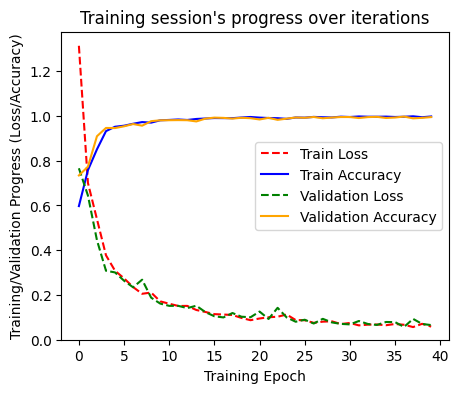

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(np.array(history.history['loss']), "r--", label = "Train Loss")
plt.plot(np.array(history.history['accuracy']), "b-", label = "Train Accuracy")
plt.plot(np.array(history.history['val_loss']), "g--", label = "Validation Loss")
plt.plot(np.array(history.history['val_accuracy']), "orange", label = "Validation Accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='center right')
plt.ylabel('Training/Validation Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

In [ ]:
# Evaluate the model
loss, local_accuracy = local_model.evaluate(X_test, Y_test)
print(f'Loss: {loss}, Accuracy: {local_accuracy}')

396/396 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9946 - loss: 0.0730
Loss: 0.0746716633439064, Accuracy: 0.9940020442008972


396/396 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


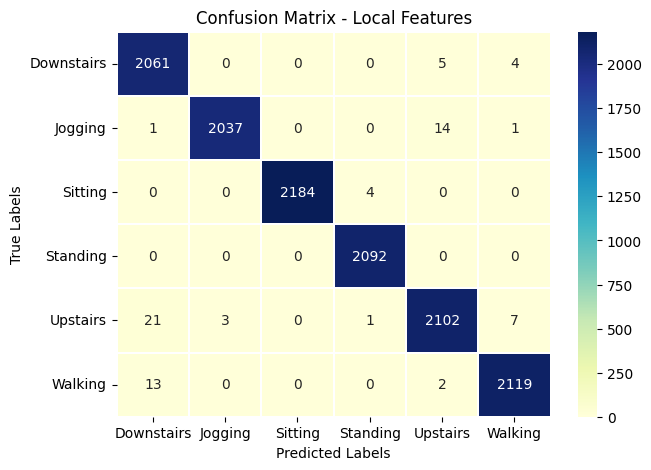

In [ ]:
# Ensure Y_test is a 1D array
max_test = Y_test if Y_test.ndim == 1 else np.argmax(Y_test, axis=1)

# Get model predictions
max_predictions = np.argmax(local_model.predict(X_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(max_test, max_predictions)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', linewidths = 0.1, xticklabels=label.classes_, yticklabels=label.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Local Features')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv1D, BatchNormalization, Activation, LSTM, Multiply, Input
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

class TemporalAttentionLayer(Layer):
    def __init__(self):
        super(TemporalAttentionLayer, self).__init__()
        self.conv1d = Conv1D(filters=n_features, kernel_size=5, strides=1, padding='same', use_bias=False)  # Reduce from 6 -> 3
        self.bn = BatchNormalization(epsilon=1e-5, momentum=0.01, trainable=True)
        self.activation = Activation("sigmoid")
        self.lstm = LSTM(3, return_sequences=True)

    def call(self, x):
        # Extract energy features per axis
        energy_features = compute_energy_features_per_axis(x)

        attention_input = self.conv1d(energy_features)
        attention_input = self.bn(attention_input)
        attention_weights = self.activation(attention_input)

        # Apply attention weights to original input
        output_tensor = Multiply()([x, attention_weights])

        # LSTM Computation
        lstm_out = self.lstm(x)

        # Residual Connection
        residual_output = tf.add(output_tensor, lstm_out)

        return residual_output

In [ ]:
# Define local model
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))  # (sequence_length, n_features)
attention_output = TemporalAttentionLayer()(inputs)

# # Add LSTM layers
x = LSTM(256, return_sequences=True)(attention_output)
x = LSTM(128, return_sequences=True)(x)
x = LSTM(64, return_sequences=False)(x)

# Add Dense layers
x = Dense(64, LeakyReLU(negative_slope= 0.1),kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(32, LeakyReLU(negative_slope= 0.1), kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dense(16, LeakyReLU(negative_slope= 0.1), kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dense(8, LeakyReLU(negative_slope= 0.1), kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

outputs = Dense(6, activation='softmax')(x)

global_model = Model(inputs=inputs, outputs=outputs)
global_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100, 3)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ temporal_attention_layer_1           │ (None, 100, 3)              │             186 │
│ (TemporalAttentionLayer)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 100, 256)            │         266,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 100, 128)            │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 519,912 (1.98 MB)

 Trainable params: 519,906 (1.98 MB)

 Non-trainable params: 6 (24.00 B)

In [ ]:
# Compile the model
global_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# Fit the model
history = global_model.fit(X_train, Y_train, epochs=40, batch_size=128, validation_data=(X_val, Y_val), verbose=1)

Epoch 1/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.4796 - loss: 1.8791 - val_accuracy: 0.7338 - val_loss: 0.7658
Epoch 2/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.7429 - loss: 0.7404 - val_accuracy: 0.7731 - val_loss: 0.6444
Epoch 3/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.8158 - loss: 0.5893 - val_accuracy: 0.9091 - val_loss: 0.4445
Epoch 4/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.9220 - loss: 0.4060 - val_accuracy: 0.9460 - val_loss: 0.3082
Epoch 5/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.9503 - loss: 0.3161 - val_accuracy: 0.9455 - val_loss: 0.3006
Epoch 6/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.9544 - loss: 0.2828 - val_accuracy: 0.9534 - val_loss: 0.2636
Epoch 7/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.9630 - loss: 0.2411 - val_accuracy: 0.9635 - val_loss: 0.2342
Epoch 8/40
528/528 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.9700 - loss: 0.2123 - 

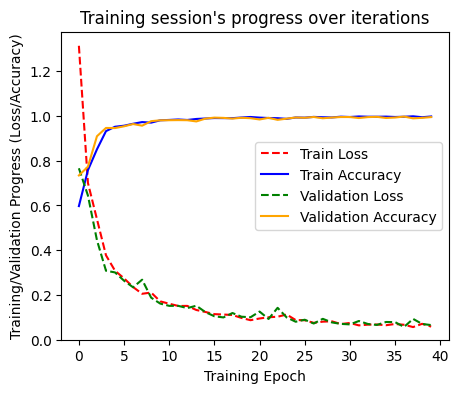

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(np.array(history.history['loss']), "r--", label = "Train Loss")
plt.plot(np.array(history.history['accuracy']), "b-", label = "Train Accuracy")
plt.plot(np.array(history.history['val_loss']), "g--", label = "Validation Loss")
plt.plot(np.array(history.history['val_accuracy']), "orange", label = "Validation Accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='center right')
plt.ylabel('Training/Validation Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

In [ ]:
# Evaluate the model
loss, global_accuracy = global_model.evaluate(X_test, Y_test)
print(f'Loss: {loss}, Accuracy: {global_accuracy}')

396/396 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9962 - loss: 0.0589
Loss: 0.06145689636468887, Accuracy: 0.9959750771522522


396/396 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


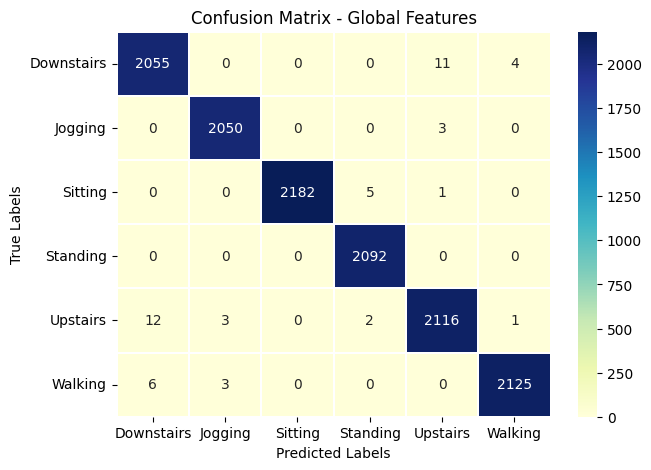

In [ ]:
# Ensure Y_test is a 1D array
max_test = Y_test if Y_test.ndim == 1 else np.argmax(Y_test, axis=1)

# Get model predictions
max_predictions = np.argmax(global_model.predict(X_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(max_test, max_predictions)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', linewidths = 0.1, xticklabels=label.classes_, yticklabels=label.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Global Features')
plt.show()

396/396 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
396/396 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Using Weights: Energy Model = 0.50, Local Model = 0.50
Weighted Fusion Accuracy: 0.9973


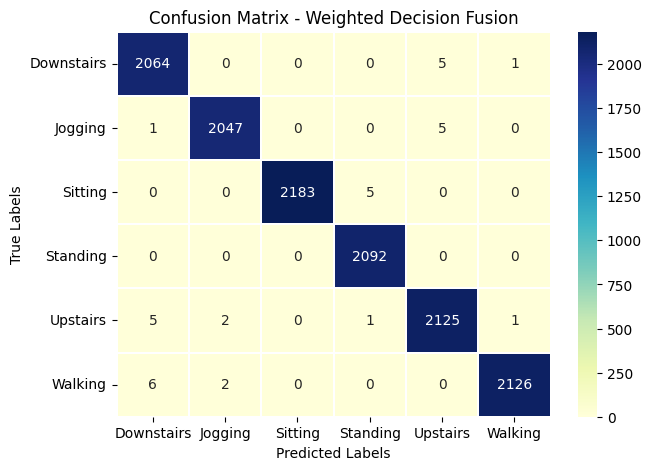

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

def weighted_fusion(energy_model, local_model, X_test, val_acc_global, val_acc_local):

    # Get softmax probabilities from both models
    prob_energy = energy_model.predict(X_test)
    prob_local = local_model.predict(X_test)

    # Compute dynamic weights (normalize validation accuracies)
    total_acc = val_acc_global + val_acc_local
    weight_global = val_acc_global / total_acc
    weight_local = val_acc_local / total_acc

    print(f"Using Weights: Energy Model = {weight_global:.2f}, Local Model = {weight_local:.2f}")

    # Compute weighted probabilities
    weighted_probs = (weight_global * prob_energy) + (weight_local * prob_local)

    # Get final predictions (argmax over weighted sum)
    final_predictions = np.argmax(weighted_probs, axis=1)

    return final_predictions

# Compute final weighted fusion predictions
combined_predictions = weighted_fusion(global_model, local_model, X_test, global_accuracy, local_accuracy)

# Compute accuracy
fusion_accuracy = accuracy_score(Y_test, combined_predictions)
print(f'Weighted Fusion Accuracy: {fusion_accuracy:.4f}')

# Compute confusion matrix
cm = confusion_matrix(Y_test, combined_predictions)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', linewidths=0.1, xticklabels=label.classes_, yticklabels=label.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Weighted Decision Fusion')
plt.show()
